# Работа по симуляции правила Гамильтона

In [1]:
##Библиотеки
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## константы настройки 
steps = 600 ## количество шагов в симуляции
hom_c = 200 ##количество домов
hun_c = 5 ##как часто встречаеться хищник (каждые h_c кормушек)
chi_c = 3 ## количество детей у одной пары
d_a = 0.95 ##вероятность сметри особи поднявшей тревогу
a_a1 = 1  ##вероятность сметри группы, если  агресивный 1
a_a2 = 0.7##вероятность сметри группы, если  агресивных 2
a_a3 = 0.4 ##вероятность сметри группы, если  агресивный 3
gen_t_hum= 'humanist'     #кодирует ген гуманизма 
gen_t_ego= 'egoist'       #кодирует ген эгоизма 
gen_t_agr= 'aggressive'   #кодирует ген агрессии
repeat=300 ##количество повторов эксперемента

In [3]:
## создание класса Особь
class Person(object):
    __slots__ = ["gen_t"]
    def __init__(self, gen):
        self.gen_t = gen

    def get_gen (self):
        return(self.gen_t)

In [4]:
## создание статического класса, который отвечает за все процессы жизнедеятельности
class life(object):
    
    ##заполняет дома особями, перед первым днём
    @staticmethod
    def first_day(hom_c,hum_c,ego_c,agr_c):
        if hum_c+ego_c+agr_c>hom_c:
            print('ERROR: семей больше чем домов')
        home_list= [None for i in range(hom_c)]  ## дома будем симулировать с поvощью двумерного массива 
        for i in range(hum_c):
            home_list[i]=[ Person(gen_t_hum) for i in range(chi_c)]
        for i in range(ego_c):
            home_list[hum_c+i]=[ Person(gen_t_ego) for i in range(chi_c)]
        for i in range(agr_c):
            home_list[hum_c+ego_c+i]=[ Person(gen_t_agr) for i in range(chi_c)]
        return  home_list
    ##отвечает за размножение пар особей в домах
    @staticmethod
    def reproduction (home_list):
        for j in range(len(home_list)) :
            if home_list[j]!=None:
                if len(home_list[j])==1:
                    home=None
                if len(home_list[j])>2: 
                    print('ERROR: в доме больше чем пара в момент размножения')
                if len(home_list[j])==2:
                    childs=[]
                    for i in range (chi_c):
                        par_gen=random.randint(0,1) ##случайным образом определяем родителя ген которго наследуеться
                        gen=home_list[j][par_gen].get_gen()
                        child=Person(gen)
                        childs.append(child)
                    home_list[j]=childs
        return home_list
    
    ##возвращает статистику по количеству типов особей в домах
    @staticmethod
    def get_stat (home_list):
        count_ego=0
        count_hum=0
        count_agr=0
        for home in home_list:
            if home!=None:
                for person in home:
                    if person.get_gen()==gen_t_hum:
                        count_hum+=1
                    elif person.get_gen()==gen_t_ego:
                        count_ego+=1
                    elif person.get_gen()==gen_t_agr:
                        count_agr+=1
        return (count_hum, count_ego, count_agr)
   
    ##описание процедуры eating на вход, получаем список домов. на выходе рандомизированый список
    ##всех выживших в процессе кормления особей.
    ## в процессе реализации воспользуемся тем, что к кормушке подходят особи из одного дома
    @staticmethod
    def eating (home_list):
        person_list=[]
        help_count=0    ##считае сколько семей прокормилось. с помощью этого коэфицента,
        ##будем определять есть ли в текущей кормушке хищьник
        
        for home in home_list:
            if home!=None:
                help_count+=1
                if help_count%hun_c!=0:
                    for per in  home:
                        person_list.append(per)
                else:
                    ##в силу слчучайного распределения порядка детей, можно без ограничения общности
                    ## принимать 0 особь за ту, уоторая увидит хищьника
                    if home[0].get_gen()==gen_t_ego: ##симуляция поведения эгоиста
                        person_list.append(home[0])
                    if home[0].get_gen()==gen_t_hum:
                        for i in range(len(home)):
                            if i==0:
                                if random.random()>d_a: ## определяем, выживет ли альтруист поднявший тревогу
                                    person_list.append(home[0])
                            else:
                                person_list.append(home[i])
                    if home[0].get_gen()==gen_t_agr:
                        coun_agr=0
                        for i in range(len(home)):
                            if home[i].get_gen()==gen_t_agr:
                                coun_agr+=1
                        if coun_agr>=3 and  random.random()>a_a3:    
                            for i in range(len(home)):
                                person_list.append(home[i])
                        if coun_agr==2 and  random.random()>a_a2:
                            for i in range(len(home)):
                                person_list.append(home[i])
                        if coun_agr==1 and  random.random()>a_a1:
                            for i in range(len(home)):
                                person_list.append(home[i])
                            
                            
        random.shuffle(person_list)       ##перемешиваем особей случайным образом  
        return(person_list)
    ##применяеться после eating для очтстки добов после кормёжки:
    @staticmethod
    def clear_home_list (home_list):
        return ([None for i in range(len(home_list))])
    ##функция отвечает за расселение пар особей по домам
    @staticmethod
    def new_pair (home_list,person_list):
        for i in range(len(person_list)//2):
            if i+1>len(home_list):
                break
            pair=[person_list[2*i],person_list[2*i+1]]
            home_list[i]=pair
        return(home_list)

In [5]:
rezylt=[]
#запуск симуляции
home_list=life.first_day(hom_c,10,10,10)
for i in range (steps):
    person_list=life.eating(home_list)
    home_list=life.clear_home_list(home_list)
    home_list=life.new_pair(home_list,person_list)
    home_list=life.reproduction(home_list)
    rezylt.append(life.get_stat(home_list))

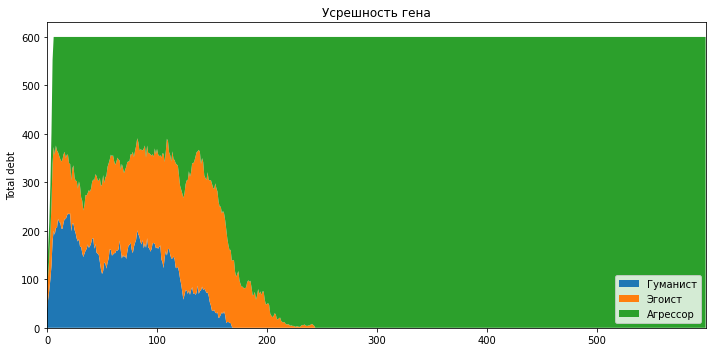

In [6]:

 
y=([i for i in rezylt])

y=np.transpose(y)
x = np.arange(steps)

 
fig, ax = plt.subplots(figsize=(10, 5))
ax.stackplot(x, y, labels=['Гуманист', 'Эгоист', 'Агрессор'])


ax.set_title('Усрешность гена')


ax.legend(loc='lower right')
ax.set_ylabel('Total debt')
ax.set_xlim(xmin=x[0], xmax=x[-1])
fig.tight_layout()
 
plt.show()

In [ ]:
rezylt_list=[]
for j in range (repeat):
    rezylt=[]
    #запуск симуляции
    home_list=life.first_day(hom_c,5,5,5)
    for i in range (steps):
        person_list=life.eating(home_list)
        home_list=life.clear_home_list(home_list)
        home_list=life.new_pair(home_list,person_list)
        home_list=life.reproduction(home_list)
        rezylt.append(life.get_stat(home_list))
    rezylt_list.append(rezylt)

In [ ]:
a=len(rezylt_list[0])
b=len(rezylt_list[0][0])
aver_result=np.zeros((a,b))
for i in range (a):
    for j in range (b):
        aver_result[i][j]=sum([rezylt_list[z][i][j] for z in range(len(rezylt_list))])/repeat

In [ ]:
y=([i for i in aver_result])

y=np.transpose(y)
x = np.arange(steps)

 
fig, ax = plt.subplots(figsize=(10, 5))
ax.stackplot(x, y, labels=['Гуманист', 'Эгоист', 'Агрессор'])




ax.set_title('Усрешность гена')


ax.legend(loc='lower right')
ax.set_ylabel('Total debt')
ax.set_xlim(xmin=x[0], xmax=x[-1])
fig.tight_layout()
 
plt.show()